In [ ]:
%load_ext tensorboard

%reload_ext tensorboard

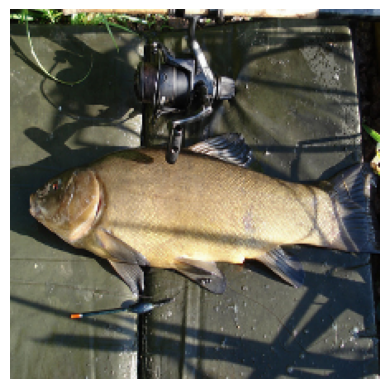

In [24]:
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pl_bolts.datamodules import ImagenetDataModule
from torchvision import transforms
import torch
import PIL.Image as pillow

img=pillow.open('data/test/fish-449.JPEG')
#x=torch.tensor
totensor=transforms.ToTensor()
topil=transforms.ToPILImage()
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
norm=transforms.Normalize(mean.tolist(),std.tolist())
revernorm=transforms.Normalize((-mean/std).tolist(),(1.0/std).tolist())
tr=transforms.RandomResizedCrop(224)
rimg=norm(tr(totensor(img)))

x=rimg.unsqueeze(0)

plt.axis('off')
plt.imshow(topil(revernorm(rimg)))

In [2]:
#print(rimg.__class__)
# from ddmim import DDMIM
# from ddmimv2 import DDMIMV2
from models.ddmimv4 import DDMIMV4
#dd=DDMIMV2.load_from_checkpoint('log/seed1/version_132/checkpoints/epoch=5-step=249999.ckpt')
# dd=DDMIMV2.load_from_checkpoint('log/seed1/version_132/checkpoints/last.ckpt')
dd=DDMIMV4.load_from_checkpoint('log/seed1/version_221/checkpoints/last.ckpt')
dd.eval()
y,mask=dd.cover(x)
print(mask[:,:10,:10])
yout=dd.to_image(y)
maskout=dd.to_image(mask)
#y=y.squeeze()
#cover=topil(revernorm(y))
plt.axis('off')
plt.imshow(yout)


RuntimeError: Error(s) in loading state_dict for DDMIMV4:
	Unexpected key(s) in state_dict: "bn.weight", "bn.bias", "bn.running_mean", "bn.running_var", "bn.num_batches_tracked". 

In [4]:
print(dd.hparams)

"alpha":          1
"channels":       3
"depths":         [2, 2, 6, 2]
"dim_head":       96
"encoder_stride": 32
"epsilon":        1e-06
"image_size":     224
"lr":             0.001
"masking_ratio":  0.5
"mlp_ratio":      4.0
"momentum":       0.9
"num_classes":    2048
"num_heads":      [3, 6, 12, 24]
"patch_size":     16
"stagefactor":    [0.2, 0.4, 0.6, 0.8]
"tau":            0.2
"weight_decay":   0.0001
"window_size":    7


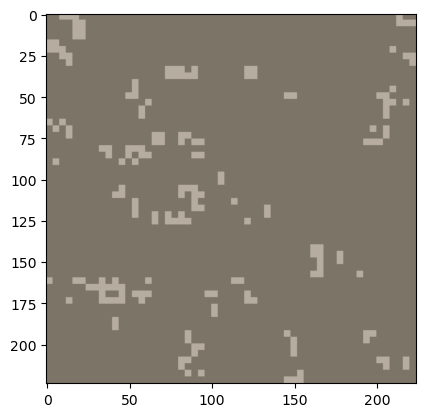

In [26]:
plt.imshow(maskout)

In [ ]:
xmm=x*mask
# ymm=

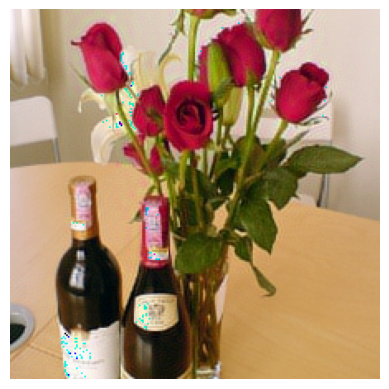

In [7]:
#print(revernorm(y))
from models.ddmimv7 import DDMIMV7
dd=DDMIMV7.load_from_checkpoint("log/seed3407/version_4/checkpoints/last.ckpt")
z=dd.inferences(x)
rc=dd.to_image(z)
plt.axis('off')
plt.imshow(rc)

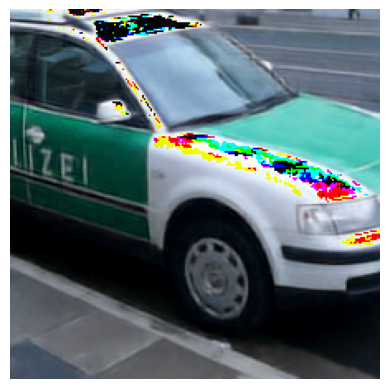

In [17]:
#print(revernorm(y))
from models.simmimforddmimv4 import SimMimForDDMIMV4
from models.ddmimv7 import DDMIMV7
dd1=SimMimForDDMIMV4.load_from_checkpoint("log/seed1/version_234/checkpoints/last.ckpt")
# dd=DDMIMV7.load_from_checkpoint("log/seed3407/version_4/checkpoints/last.ckpt")
dd1.train(False)
dd1.masking_ratio=0.5
z1=dd1.inferences(x)
rc1=dd1.to_image(z1)
plt.axis('off')
plt.imshow(rc1)

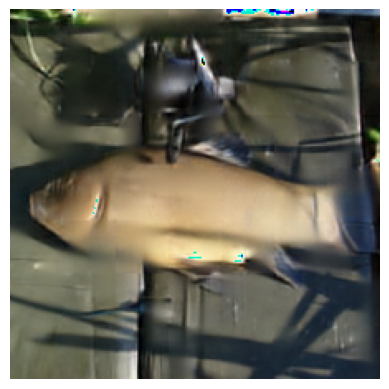

In [25]:
from visualizer import get_local
get_local.activate() # 激活装饰器
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from model.simmimforddmimv4 import SimMimForDDMIMV4
class cover_simmim(SimMimForDDMIMV4):
    def cover(self,x):
        # get patches
        with torch.no_grad():
            origin=x.clone()
            total_mask=torch.ones(x.shape)
            x = self.encoder.patch_embed(x)

            # assert mask is not None
            B, L, _ = x.shape

            
            if self.encoder.ape:
                x = x + self.absolute_pos_embed
            x = self.encoder.pos_drop(x)
            x_masked =x
            for i_layer,layer in enumerate(self.encoder.layers):

                if i_layer == 0:
                    B, L, D = x_masked.shape
                    H = W = int(L ** 0.5)
                    # mask=torch.ones(x.shape).to(device=x.device)
                    sizetimes=4
                    small_mask=torch.ones([B,int(L/(sizetimes**2)),D])
                    small_mask=F.dropout2d(small_mask,self.masking_ratio)*(1-self.masking_ratio)
                    # mask=F.dropout2d(mask,self.masking_ratio)*(1-self.masking_ratio)
                    mask=repeat(small_mask,"b (h w) d->b (h r1 w r2) d",h=int(H/sizetimes),w=int(W/sizetimes),r1=sizetimes,r2=sizetimes)
                    #update the total mask
                    
                    expend_mask = rearrange(mask,"b (h w) d -> b d h w",h=H,w=W)
                    expend_mask=repeat(expend_mask[:,:self.hparams.channels,:,:],"b d h w-> b d (h r1) (w r2)",h=H,w=W,r1=2 ** (i_layer+2),r2=2 ** (i_layer+2))
                    total_mask=total_mask*expend_mask
                    
                    #masking
                    x_masked=x_masked*mask
                
                # mask=torch.ones(x_masked.shape)
                # mask=F.dropout2d(mask,self.masking_ratio)*(1-self.masking_ratio)
                
                # #update the total mask
                # B, L, _ = x_masked.shape
                # H = W = int(L ** 0.5)
                # expend_mask = rearrange(mask,"b (h w) d -> b d h w",h=H,w=W)
                # expend_mask=repeat(expend_mask[:,:self.channels,:,:],"b d h w-> b d (h r1) (w r2)",h=H,w=W,r1=2 ** (i_layer+2),r2=2 ** (i_layer+2))
                # total_mask=total_mask*expend_mask
                
                # #masking
                # x_masked=x_masked*mask
                
                # # x = layer(x)
                x_masked=layer(x_masked)
                
                
            x_masked = self.encoder.norm(x_masked)    
            x_masked = x_masked.transpose(1, 2)
            B, C, L = x_masked.shape
            H = W = int(L ** 0.5)
            x_masked = x_masked.reshape(B, C, H, W)
            x_masked=self.decoder(x_masked)
            return x_masked,total_mask
get_local.clear()
dd1=cover_simmim.load_from_checkpoint("log/seed1/version_234/checkpoints/last.ckpt")        
dd1.masking_ratio=0.5
z1m,mask1=dd1.cover(x)
rc1m=dd1.to_image(z1m)
plt.axis('off')
plt.imshow(rc1m)

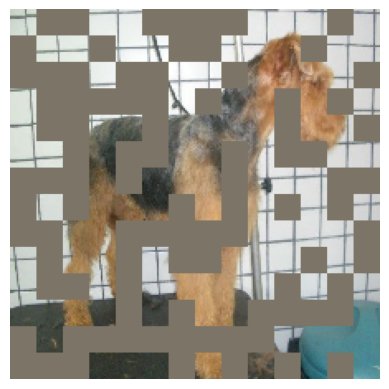

In [12]:
import torch.nn.functional as F
from einops import rearrange
x1_masked=x.clone()


# mask=torch.ones(x_masked.shape)
# mask=rearrange(mask,'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',h=56,w=56,s1=4,s2=4)
# mask=F.dropout2d(mask,0.75)*(1-0.75)
# mask=rearrange(mask,'b (h w) (s1 s2 c) -> b c (h s1) (w s2)',h=56,w=56,s1=4,s2=4)
# print(mask[:10:10])
x1_masked=x1_masked*mask1
x1m=dd1.to_image(x1_masked)
plt.axis('off')
plt.imshow(x1m)

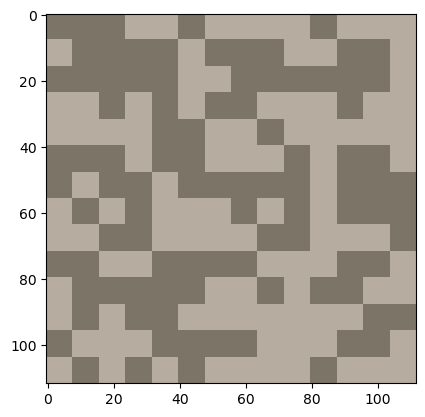

In [40]:
import torch.nn.functional as F
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from models.ddmimv6 import DDMIMV6
tmp=rearrange(mask1,"b d (h r1) (w r2)-> b (d r1 r2) h w",r1=2,r2=2)
maskout=dd1.to_image(tmp[:,:3,:,:])
plt.imshow(maskout)

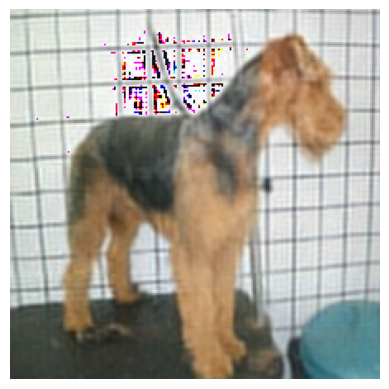

In [14]:
#print(revernorm(y))
from models.simmimforddmimv4 import SimMimForDDMIMV4
from models.ddmimv6 import DDMIMV6
from models.ddmimv7 import DDMIMV7
# dd1=SimMimForDDMIMV4.load_from_checkpoint("log/seed1/version_234/checkpoints/last.ckpt")
dd2=DDMIMV6.load_from_checkpoint("log/seed1/version_254/checkpoints/epoch=41-step=844999.ckpt")
# dd=DDMIMV7.load_from_checkpoint("log/seed3407/version_4/checkpoints/last.ckpt")
dd2.train(False)
z2=dd2.inferences(x)
rc2=dd2.to_image(z2)
plt.axis('off')
plt.imshow(rc2)

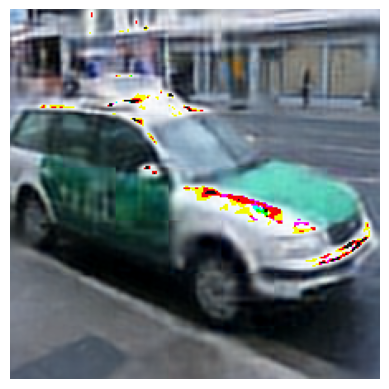

In [11]:
#print(revernorm(y))
from models.simmimforddmimv4 import SimMimForDDMIMV4
from models.ddmimv6 import DDMIMV6
from models.ddmimv7 import DDMIMV7
# dd1=SimMimForDDMIMV4.load_from_checkpoint("log/seed1/version_234/checkpoints/last.ckpt")
# dd2=DDMIMV6.load_from_checkpoint("log/seed1/version_254/checkpoints/epoch=41-step=844999.ckpt")
# dd=DDMIMV7.load_from_checkpoint("log/seed3407/version_4/checkpoints/last.ckpt")
# dd2.train(False)
z2m,mask=dd2.cover(x)
rc2m=dd2.to_image(z2m)
plt.axis('off')
plt.imshow(rc2m)


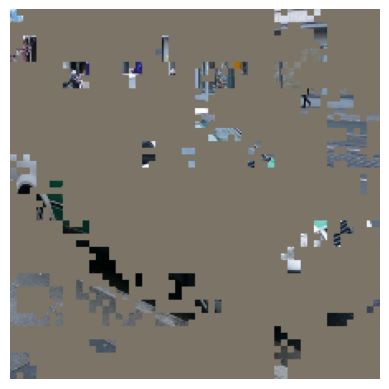

In [12]:
import torch.nn.functional as F
from einops import rearrange
x_masked=x.clone()


# mask=torch.ones(x_masked.shape)
# mask=rearrange(mask,'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',h=56,w=56,s1=4,s2=4)
# mask=F.dropout2d(mask,0.75)*(1-0.75)
# mask=rearrange(mask,'b (h w) (s1 s2 c) -> b c (h s1) (w s2)',h=56,w=56,s1=4,s2=4)
# print(mask[:10:10])
x_masked=x_masked*mask
xm=dd2.to_image(x_masked)
plt.axis('off')
plt.imshow(xm)

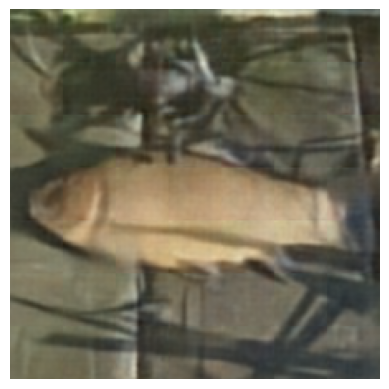

In [28]:
from visualizer import get_local

import torch.nn.functional as F
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange


from model.ddmimv6 import DDMIMV6
from model.ddmimv7 import DDMIMV7
class cover_ddmimv7(DDMIMV7):
    def cover(self,x):
        masking_ratio=0.75
        # get patches
        with torch.no_grad():
            origin=x.clone()
            total_mask=torch.ones(x.shape)
            x = self.encoder.patch_embed(x)

            # assert mask is not None
            B, L, _ = x.shape

            
            if self.encoder.ape:
                x = x + self.absolute_pos_embed
            x = self.encoder.pos_drop(x)
            x_masked =x
            for i_layer,layer in enumerate(self.encoder.layers):

                # if i_layer == 0:
                if i_layer==1:
                    B, L, D = x_masked.shape
                    H = W = int(L ** 0.5)
                    # mask=torch.ones(x.shape).to(device=x.device)
                    sizetimes=2
                    small_mask=torch.ones([B,int(L/(sizetimes**2)),D])
                    small_mask=F.dropout2d(small_mask,self.masking_ratio[i_layer])*(1-self.masking_ratio[i_layer])
                    # mask=F.dropout2d(mask,self.masking_ratio)*(1-self.masking_ratio)
                    # mask=repeat(small_mask,"b (h w) d->b (h r1 w r2) d",h=int(H/sizetimes),w=int(W/sizetimes),r1=sizetimes,r2=sizetimes)
                    mask=rearrange(mask1,"b d (h r1) (w r2)-> b (h w) (d r1 r2)",r1=2 ** (i_layer+2),r2=2 ** (i_layer+2))
                    mask=mask[:,:L,:D]
                    #update the total mask
                    
                    expend_mask = rearrange(mask,"b (h w) d -> b d h w",h=H,w=W)
                    expend_mask=repeat(expend_mask[:,:self.hparams.channels,:,:],"b d h w-> b d (h r1) (w r2)",h=H,w=W,r1=2 ** (i_layer+2),r2=2 ** (i_layer+2))
                    total_mask=total_mask*expend_mask
                    
                    #masking
                    x_masked=x_masked*mask
                
                # x = layer(x)
                x_masked=layer(x_masked)
                
                
            x_masked = self.encoder.norm(x_masked)    
            x_masked = x_masked.transpose(1, 2)
            B, C, L = x_masked.shape
            H = W = int(L ** 0.5)
            x_masked = x_masked.reshape(B, C, H, W)
            x_masked=self.decoder(x_masked)
            return x_masked,total_mask






# dd3=cover_ddmim.load_from_checkpoint("log/seed1/version_254/checkpoints/epoch=41-step=844999.ckpt")
dd3=cover_ddmimv7.load_from_checkpoint("log/seed3407/version_10/checkpoints/last.ckpt")
dd3.masking_ratio=[0.5,0.5,0.5,0.5]
z3m,mask3=dd3.cover(x)
rc3m=dd3.to_image(z3m)
plt.axis('off')
plt.imshow(rc3m)

In [29]:
import numpy as np
from einops import rearrange,reduce,repeat

cache = get_local.cache
print(list(cache.keys()))
attnmap=np.array(cache["WindowAttention.forward"],dtype=object)
print(attnmap.shape)
print(attnmap[-1].shape)
lasta=torch.tensor(attnmap[-1])
lasta=reduce(lasta,"b d h w->b w","mean")
lasta=rearrange(lasta,"b (h w)-> b h w",h=7,w=7)
lasta=repeat(lasta,"b h w-> b (h r1) (w r2)",r1=32,r2=32)
maskl=(lasta/lasta.max()*255).numpy()[0].astype("uint8")


print(lasta)
print(lasta.shape)

['WindowAttention.forward']
(24,)
(1, 24, 49, 49)
tensor([[[0.0165, 0.0165, 0.0165,  ..., 0.0200, 0.0200, 0.0200],
         [0.0165, 0.0165, 0.0165,  ..., 0.0200, 0.0200, 0.0200],
         [0.0165, 0.0165, 0.0165,  ..., 0.0200, 0.0200, 0.0200],
         ...,
         [0.0193, 0.0193, 0.0193,  ..., 0.0187, 0.0187, 0.0187],
         [0.0193, 0.0193, 0.0193,  ..., 0.0187, 0.0187, 0.0187],
         [0.0193, 0.0193, 0.0193,  ..., 0.0187, 0.0187, 0.0187]]])
torch.Size([1, 224, 224])


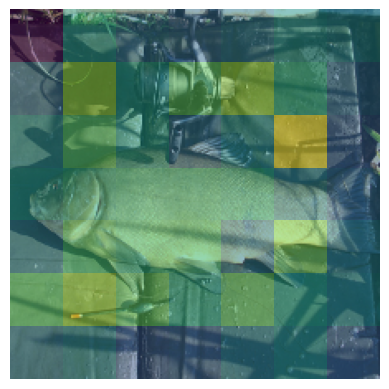

In [30]:
import torch.nn.functional as F
from einops import rearrange
x3_masked=x.clone()


# mask=torch.ones(x_masked.shape)
# mask=rearrange(mask,'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',h=56,w=56,s1=4,s2=4)
# mask=F.dropout2d(mask,0.75)*(1-0.75)
# mask=rearrange(mask,'b (h w) (s1 s2 c) -> b c (h s1) (w s2)',h=56,w=56,s1=4,s2=4)
# print(mask[:10:10])
x3m=dd1.to_image(x3_masked)
# x3m=dd3.to_image(x3_masked)
plt.axis('off')
plt.imshow(x3m)
plt.imshow(maskl,alpha=0.5,interpolation="nearest")

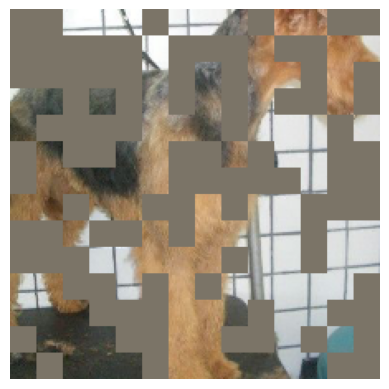

In [17]:
import torch.nn.functional as F
from einops import rearrange
x3_masked=x.clone()


# mask=torch.ones(x_masked.shape)
# mask=rearrange(mask,'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',h=56,w=56,s1=4,s2=4)
# mask=F.dropout2d(mask,0.75)*(1-0.75)
# mask=rearrange(mask,'b (h w) (s1 s2 c) -> b c (h s1) (w s2)',h=56,w=56,s1=4,s2=4)
# print(mask[:10:10])
x3_masked=x3_masked*mask3
x3m=dd3.to_image(x3_masked)
plt.axis('off')
plt.imshow(x3m)

In [23]:
l=torch.tensor([[0]])
k=dd.training_step([x,l],0)
k

/opt/conda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(0.8186, grad_fn=<AddBackward0>)

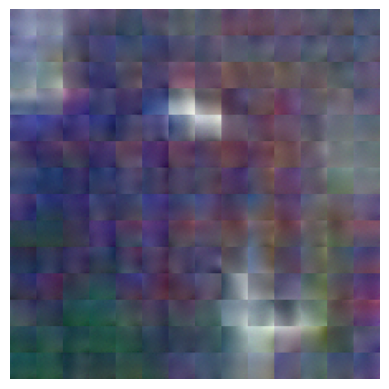

In [23]:

s0=plt.imread("stage0.jpg")
cc=norm(tr(totensor(s0))).unsqueeze(0)
zd=dd(cc)
rcd=dd.to_image(zd[:,:-1])
plt.axis('off')
plt.imshow(rcd)

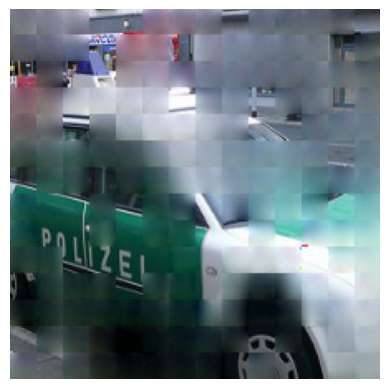

In [24]:
s3=plt.imread("stage3.jpg")
plt.axis('off')
plt.imshow(s3)

torch.Size([512])


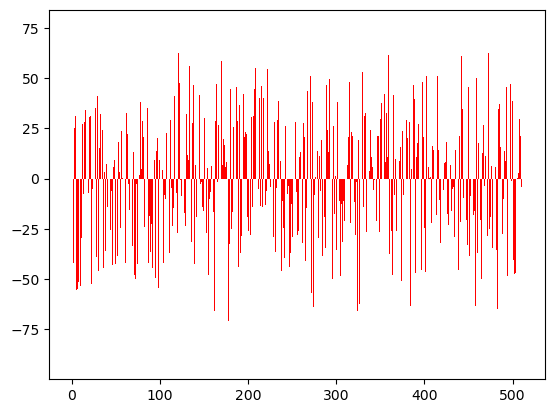

In [3]:
from models.ddmimv7 import DDMIMV7
cls_model=DDMIMV7.load_from_checkpoint("log/seed3407/version_10/checkpoints/last.ckpt")


cls1=cls_model.repersentation(x).squeeze(0)
print(cls1.shape)
dim=range(cls1.shape[0])
plt.bar(dim,cls1.detach().numpy(),color="red")

plt.show()

torch.Size([512])


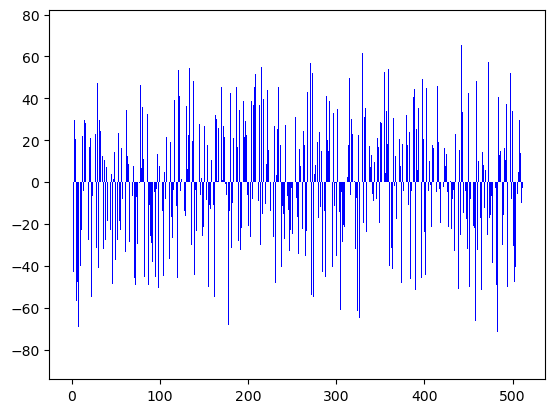

In [5]:
from models.ddmimv7 import DDMIMV7
cls_model=DDMIMV7.load_from_checkpoint("log/seed3407/version_10/checkpoints/last.ckpt")


cls2=cls_model.repersentation(x).squeeze(0)
print(cls2.shape)
dim=range(cls2.shape[0])
plt.bar(dim,cls2.detach().numpy(),color="blue")

plt.show()

torch.Size([512])


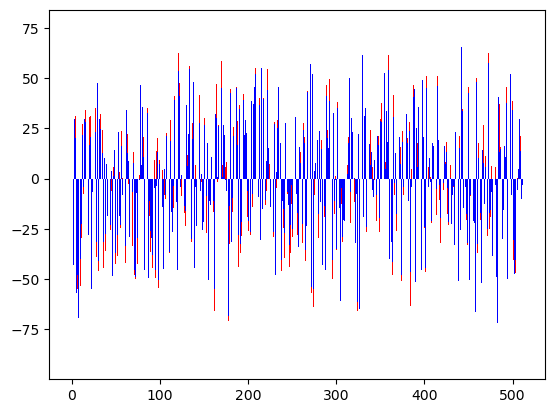

In [6]:
diff=cls1-cls2
print(diff.shape)
dim=range(diff.shape[0])
# plt.bar(dim,diff.detach().numpy(),color="green")
plt.bar(dim,cls1.detach().numpy(),color="red")
plt.bar(dim,cls2.detach().numpy(),color="blue")
plt.show()

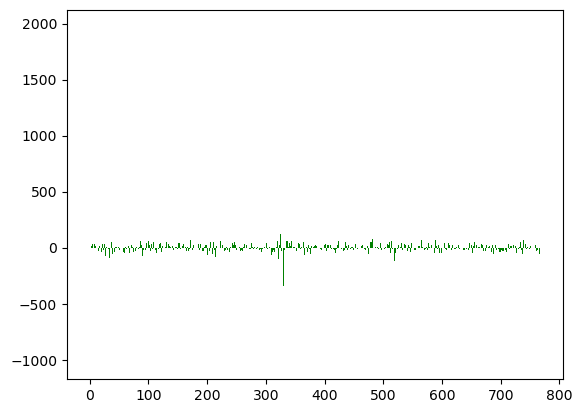

In [11]:
zcls=z[:,-1].squeeze(0)
#print(cls)
dim=range(zcls.shape[0])
plt.bar(dim,zcls.detach().numpy(),color="green")

plt.show()

In [ ]:
import os
#print(os.listdir("log/seed1/version_59/checkpoints/"))
from classifier import Classifier
#cc=Classification(resume="log/seed1/version_44/checkpoints/lask.ckpt")
cc=Classifier.load_from_checkpoint("log/seed1/version_99/checkpoints/last.ckpt")
cc.eval()
y=cc(x)
print(torch.topk(y,5))
#torch.nn.functional.cross_entropy()

tensor([[[[ 0.8636,  1.0470,  2.1975,  ...,  1.8014,  1.8201,  1.7532],
          [ 0.9389,  2.1164,  2.1424,  ...,  1.6771,  1.7852,  1.7528],
          [ 1.8624,  2.1328,  2.0430,  ...,  1.7653,  1.7991,  1.7668],
          ...,
          [ 2.0346,  2.0584,  1.9106,  ...,  1.4410,  1.4516,  1.4659],
          [ 1.9949,  1.9287,  1.8322,  ...,  1.4269,  1.4122,  1.4116],
          [ 2.0261,  2.0064,  1.9372,  ...,  1.4269,  1.4269,  1.4269]],

         [[ 0.5749,  0.7810,  1.9968,  ...,  1.6221,  1.6401,  1.6062],
          [ 0.6527,  1.9369,  1.9967,  ...,  1.6200,  1.6551,  1.5910],
          [ 1.5977,  2.0164,  1.9028,  ...,  1.6236,  1.6431,  1.6032],
          ...,
          [ 2.0209,  1.9682,  1.8201,  ...,  0.8323,  0.8323,  0.8039],
          [ 1.9233,  1.8236,  1.7400,  ...,  0.8179,  0.8179,  0.8216],
          [ 1.9554,  1.9181,  1.8473,  ...,  0.8179,  0.8179,  0.8525]],

         [[ 0.4423,  0.3716,  1.5781,  ...,  1.6861,  1.8320,  1.7523],
          [ 0.3650,  1.4434,  

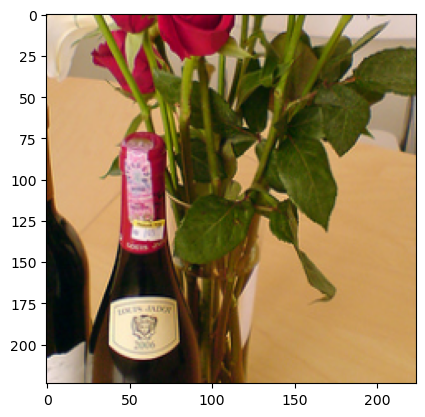

In [11]:
print(x)
te=x.squeeze(0)
plt.imshow(topil(revernorm(te)))

In [1]:
from config.option import parse_args

from pl_bolts.datamodules import ImagenetDataModule
#args= parse_args()
datamodule=ImagenetDataModule("../imagenet2012",batch_size=4)

tdl=datamodule.train_dataloader()
for data in tdl:
    x,y=data
    print(x.shape)
    print(y)

/opt/conda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/opt/conda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


: 

: 

In [1]:
# import classifier
# import ddmimv2
import torchinfo
# import vit
# import os
import torch
# import swinTransformerV2
# import simmim
# import maxvit
# import DDMIM.model.selfvit as selfvit
# import DDMIM.model.selfvitV2 as selfvitV2
# import ddmimv4
# import model.ddmimv6 as ddmimv6
# import model.ddmimv7 as ddmim
from models.ddmimv9 import DDMIMV9
#model=classifier.Classifier(resume='DDMIM/log/seed1/version_44/checkpoints/last.ckpt')

# model=ddmimv2.DDMIMV2(
#         image_size=224,
#         patch_size=16,
#         tsfm_dim=768,
#         stages_depth=[2,2,6,2],
#         heads=12,
#         mlp_dim=3096,
#         channels=3,
#         dim_head=64,
#         masking_ratio=0.75,
#         stagefactor=[1e-4,1e-3,0.01,0.1],
#         #lr=args.lr,
#         #momentum=args.momentum,
#         #weight_decay=args.weight_decay,
#         tau=0.5,
#         alpha=1
#         )
'''
model=vit.ViT(
    image_size=224,
    patch_size=16,
    num_classes=1000,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=64,
    dim_head=128
)
'''
# model=simmim.SwinTransformerV2ForSimMIM(
#             img_size=224,
#             #patch_size=patch_size,
#             in_chans=3,
#             num_classes=0,
#             embed_dim=96,
#             depths=[2,2,6,2]
#             #num_heads=config.MODEL.SWINV2.NUM_HEADS,
#             #window_size=config.MODEL.SWINV2.WINDOW_SIZE,
#             #mlp_ratio=config.MODEL.SWINV2.MLP_RATIO,
#             #qkv_bias=config.MODEL.SWINV2.QKV_BIAS,
#             #drop_rate=config.MODEL.DROP_RATE,
#             #drop_path_rate=config.MODEL.DROP_PATH_RATE,
#             #ape=config.MODEL.SWINV2.APE,
#             #patch_norm=config.MODEL.SWINV2.PATCH_NORM,
#             #use_checkpoint=config.TRAIN.USE_CHECKPOINT)
#         )
# model=swinTransformerV2.SwinTransformerV2()
# model=maxvit.MaxViT(
#     dim=64,
#     num_classes=0,
#     depth=(2,2,5,2),
#     dim_conv_stem=64,
    
# )
# model=selfvit.SelfViT(
#     dim=96,
#     num_classes=1000,
#     depth=[2,2,6,2],
#     heads=[3,6,12,24],
#     dim_conv_stem=64,
#     dim_head=32
# )
# model=selfvitV2.SelfViT(
#     dim=96,
#     num_classes=1000,
#     depth=[2,2,6,2],
#     # heads=[3,6,12,24],
#     dim_stem=64,
#     dim_head=96
# )
# model=ddmimv4.DDMIMV4.load_from_checkpoint("log/seed1/version_220/checkpoints/last.ckpt")
# torch.nn.Dropout()
# model=ddmimv6.DDMIMV6.load_from_checkpoint("log/seed1/version_254/checkpoints/last.ckpt")
# model=ddmimv7.DDMIMV7.load_from_checkpoint("log/seed3407/version_4/checkpoints/last.ckpt")
model=DDMIMV9()
model.train(False)
x=torch.rand([3,3,224,224])
y=torch.ones([3,1])
# print(model(x).shape)
print(model.training_step([x,y],0))

# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(torchinfo.summary(model,depth=7,input_size=[1,3,224,224],device="cpu"))


/opt/conda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(1.8803, grad_fn=<AddBackward0>)
Layer (type:depth-idx)                                  Output Shape              Param #
DDMIMV9                                                 [1, 1024]                 31,515,434
├─SwinTransformerV2: 1-1                                --                        --
│    └─PatchEmbed: 2-1                                  [1, 3136, 96]             --
│    │    └─Conv2d: 3-1                                 [1, 96, 56, 56]           4,704
│    │    └─LayerNorm: 3-2                              [1, 3136, 96]             192
│    └─Dropout: 2-2                                     [1, 3136, 96]             --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-3                             [1, 784, 192]             --
│    │    │    └─ModuleList: 4-1                        --                        --
│    │    │    │    └─SwinTransformerBlock: 5-1         [1, 3136, 96]             --
│    │   

In [1]:
import classifier
import models.ddmimv2
import torchinfo
import models.vit
import os
import torch
#import torch.nn as nn
from models.swinTransformerV2 import SwinTransformerV2
import models.swinTransformer 
import models.simmim
import models.maxvit
import models.selfvit as selfvit
from models.hivit import HiViT
from models.hivit_mae import HiViTMaskedAutoencoder
from models.models_mae import mae_vit_small_patch16
from functools import partial
#model=classifier.Classifier(resume='DDMIM/log/seed1/version_44/checkpoints/last.ckpt')

# model=ddmimv2.DDMIMV2(
#         image_size=224,
#         patch_size=16,
#         tsfm_dim=768,
#         stages_depth=[2,2,6,2],
#         heads=12,
#         mlp_dim=3096,
#         channels=3,
#         dim_head=64,
#         masking_ratio=0.75,
#         stagefactor=[1e-4,1e-3,0.01,0.1],
#         #lr=args.lr,
#         #momentum=args.momentum,
#         #weight_decay=args.weight_decay,
#         tau=0.5,
#         alpha=1
#         )

# model=vit.ViT(
#     image_size=224,
#     patch_size=16,
#     num_classes=1000,
#     dim=1024,
#     depth=12,
#     heads=8,
#     mlp_dim=64,
#     dim_head=128
# )

# model=simmim.SwinTransformerV2ForSimMIM(
#             img_size=224,
#             #patch_size=patch_size,
#             in_chans=3,
#             num_classes=0,
#             embed_dim=96,
#             depths=[2,2,6,2]
#             #num_heads=config.MODEL.SWINV2.NUM_HEADS,
#             #window_size=config.MODEL.SWINV2.WINDOW_SIZE,
#             #mlp_ratio=config.MODEL.SWINV2.MLP_RATIO,
#             #qkv_bias=config.MODEL.SWINV2.QKV_BIAS,
#             #drop_rate=config.MODEL.DROP_RATE,
#             #drop_path_rate=config.MODEL.DROP_PATH_RATE,
#             #ape=config.MODEL.SWINV2.APE,
#             #patch_norm=config.MODEL.SWINV2.PATCH_NORM,
#             #use_checkpoint=config.TRAIN.USE_CHECKPOINT)
#         )
# model=swinTransformer.SwinTransformer()
# model=SwinTransformerV2()

# model=HiViTMaskedAutoencoder(
#         embed_dim=512, depths=[2, 2, 8], num_heads=8, stem_mlp_ratio=3., mlp_ratio=4., 
#         decoder_embed_dim=512, decoder_depth=6, decoder_num_heads=16, hifeat=True,
#         rpe=False, norm_layer=partial(torch.nn.LayerNorm, eps=1e-6))

# model=maxvit.MaxViT(
#     dim=64,
#     num_classes=0,
#     depth=(2,2,5,2),
#     dim_conv_stem=64,
    
# )
# model=selfvit.SelfViT(
#     dim=96,
#     num_classes=1000,
#     depth=[2,2,6,2],
#     dim_conv_stem=64,
#     dim_head=96
# )
model=mae_vit_small_patch16()

x=torch.rand([1,3,224,224])
print(model(x))

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(torchinfo.summary(model,depth=6,input_size=[1,3,224,224],device="cpu"))


[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
(tensor(0.7634, grad_fn=<DivBackward0>), tensor([[[ 0.5568,  0.0056, -0.0172,  ..., -0.7411, -0.0725,  0.6164],
         [ 0.5761, -0.0823,  0.0613,  ..., -0.6966, -0.1884,  0.6014],
         [ 0.6026, -0.1831,  0.0631,  ..., -0.6508, -0.2680,  0.6006],
         ...,
         [-0.7793,  0.0698, -0.3825,  ..., -0.3793,  0.2901,  0.1511],
         [-0.7582,  0.1924, -0.3827,  ..., -0.2856,  0.1984,  0.3034],
         [ 0.2831,  0.4874, -0.0351,  ..., -0.4234,  0.1475,  1.1808]]],
       grad_fn=<SliceBackward>), tensor([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
         0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.

In [27]:
import torch.nn.functional as F
n=2
l_pos=torch.tensor([[1],[1]])#torch.ones([n,1])

# negative logits: NxN
l_neg=torch.tensor([[1,0],[0,1]])#torch.eye(n)
# print(l_neg)

# logits: Nx(1+N)
logits=torch.cat([l_pos,l_neg],dim=1)/0.2

labels=torch.zeros(n,dtype=torch.long).to(device=x.device)
contractive_loss=F.cross_entropy(logits,labels)
print(contractive_loss)

tensor(0.6965)


In [8]:
import torch
from einops import rearrange
x=torch.rand([1,96,56,56])
x=rearrange(x,'b d (w1 x) (w2 y) -> (b x y) (w1 w2) d', w1 = 7, w2 = 7)
count=56//7
print(x.shape)
# recover from window
x=rearrange(x,'(b x y) (w1 w2) d -> b d (w1 x) (w2 y)',b=1,w1 = 7, w2 = 7,x=count)
print(x.shape)

torch.Size([64, 49, 96])
torch.Size([1, 96, 56, 56])


In [9]:
from timm.models.layers import DropPath
import torch
import torch.nn as nn
a=torch.rand([2,10,5])
# shape = (a.shape[0],) + (1,) * (a.ndim - 1) 
# print(shape)
# random_tensor = a.new_empty(shape).bernoulli_(0.5)
# print(random_tensor)
b=DropPath(0.1)
c=nn.Dropout2d(0.3)
d=torch.ones(a.shape)*(1-0.3)
print(c(d)) 

tensor([[[1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])


In [8]:
import torch
n=3
c=10

a=torch.rand([n,c])
b=torch.rand([n,c])
print(torch.cosine_similarity(a,b))
print(torch.cosine_similarity(a[:1],b[:1]))

# log=torch.cat([torch.ones([n,1]),torch.eye(n)])


tensor([0.9205, 0.6861, 0.8185])
tensor([0.9205])


In [6]:
import torch
import torch.nn.functional as F
a=torch.randn([10,10])
b=torch.randn([10,10])
l_pos=torch.cosine_similarity(a,a).unsqueeze(-1)
        
        
        
        
        
# negative logits: NxN
# l_neg=torch.einsum("nc,mc->nm",[x_masked_cls,x_cls])
l_neg=torch.cosine_similarity(a.unsqueeze(1),a.unsqueeze(0),dim=2)



# logits: Nx(1+N)
logits=torch.cat([l_pos,l_neg],dim=1)/(0.02)
# logits=F.layer_norm(logits,[logits.shape[-1]])
labels=torch.zeros(10,dtype=torch.long)
contractive_loss=F.cross_entropy(logits,labels)
print(contractive_loss)

tensor(0.6931)


In [5]:
from pytorch_lightning.plugins.io import TorchCheckpointIO as tcio
tc=tcio()
ckpt_dict=tc.load_checkpoint("log/seed1/version_222/checkpoints/last.ckpt")
for key in ckpt_dict['state_dict'].keys():
    print(key)

model.encoder.patch_embed.proj.weight
model.encoder.patch_embed.proj.bias
model.encoder.patch_embed.norm.weight
model.encoder.patch_embed.norm.bias
model.encoder.layers.0.blocks.0.norm1.weight
model.encoder.layers.0.blocks.0.norm1.bias
model.encoder.layers.0.blocks.0.attn.logit_scale
model.encoder.layers.0.blocks.0.attn.q_bias
model.encoder.layers.0.blocks.0.attn.v_bias
model.encoder.layers.0.blocks.0.attn.relative_coords_table
model.encoder.layers.0.blocks.0.attn.relative_position_index
model.encoder.layers.0.blocks.0.attn.cpb_mlp.0.weight
model.encoder.layers.0.blocks.0.attn.cpb_mlp.0.bias
model.encoder.layers.0.blocks.0.attn.cpb_mlp.2.weight
model.encoder.layers.0.blocks.0.attn.qkv.weight
model.encoder.layers.0.blocks.0.attn.proj.weight
model.encoder.layers.0.blocks.0.attn.proj.bias
model.encoder.layers.0.blocks.0.norm2.weight
model.encoder.layers.0.blocks.0.norm2.bias
model.encoder.layers.0.blocks.0.mlp.fc1.weight
model.encoder.layers.0.blocks.0.mlp.fc1.bias
model.encoder.layers.0.

In [57]:
import torch
import torch.nn.functional as F

a=torch.ones([3,3,3])
b=torch.randn([3,3,3])+a+2
loss=F.kl_div(b,a)
print(loss)

tensor(-2.9912)
